In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import cPickle as pickle

In [8]:
import json
from mapper.osmloader import OsmLoader

# osm_path = 'data/osm/osm_nyc.json'
# osm = OsmLoader(osm_path)

In [3]:
G = osm.get_graph()
print len(G.nodes()), len(G.edges())

22759 45474


In [4]:
print G.nodes(data=True)[0]
print G.edges(data=True)[0]

(42860546, {'lat': 40.7436274, 'lon': -73.9404517})
(42860546, 42872051, {'bearing': [-3.0078, -3.0059, -2.5879, -2.4141], 'length': 162.0, 'lat': [40.743627400000001, 40.743009800000003, 40.742887099999997, 40.742666, 40.742330000000003], 'seg_length': [0.0, 69.312, 83.062, 112.0], 'lon': [-73.940451699999997, -73.940561099999996, -73.9405833, -73.940763500000003, -73.941158000000001], 'id': 1826})


In [56]:
nsegs = []
n = 0
for s, e, data in G.edges_iter(data=True):
    if 'lat' in data:
        nsegs.append(len(data['lat']))
    else:
        n += 1
print n

29359


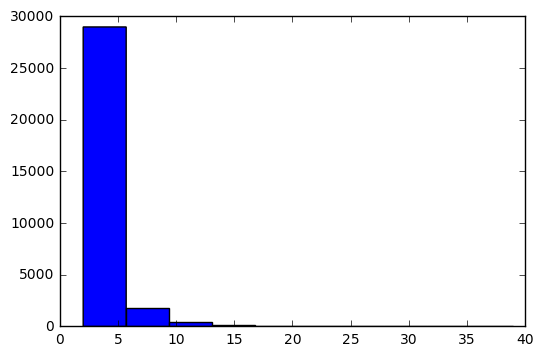

In [55]:
plt.hist(nsegs);

In [5]:
path = 'data/nyc_network_graph.pkl'
with open(path, 'wb') as f:
    pickle.dump(G, f)

In [2]:
path = 'data/nyc_network_graph.pkl'
with open(path, 'r') as f:
    G = pickle.load(f)

In [3]:
df = pd.read_csv('temp/data/taxi_tripdata_2016-05.csv', nrows=100)
df = df[df.trip_time>0][df.second<60*10]
df.head()

,request_id,date,dayofweek,dropoff_latitude,dropoff_longitude,hour,minute,pickup_latitude,pickup_longitude,second,trip_distance,trip_time,great_circle_distance
0,0,1,6,40.702751,-73.921951,0,0,40.712791,-73.965874,0,2.93,15.216667,3866
1,1,1,6,40.767826,-73.980797,0,0,40.750507,-73.987198,0,1.48,6.516667,1999
2,2,1,6,40.855343,-73.937805,0,0,40.780739,-73.981544,0,6.68,15.716667,9075
3,3,1,6,40.737564,-73.997498,0,0,40.740192,-74.005280,0,0.56,6.650000,717
4,4,1,6,40.758469,-73.988014,0,0,40.755764,-73.979294,0,0.63,5.316667,793


In [72]:
from pathgenerator import PathGenerator

path_generator = PathGenerator(G)

In [73]:
i = 10
origin = df[['pickup_latitude', 'pickup_longitude']].values[i]
destination = df[['dropoff_latitude', 'dropoff_longitude']].values[i]
trip_time = df['trip_time'].values[i]

In [77]:
%%time
path = path_generator.get_path(origin, destination, trip_time)

CPU times: user 63 ms, sys: 7.68 ms, total: 70.6 ms
Wall time: 69.2 ms


In [78]:
from mapping_utils import visualize_trajectory
visualize_trajectory(
    center_lat_lon=origin,
    blue_lat_lon=path,
    blue_radius=[5]*len(path),
    marker_locs=[origin, destination,]
)

file created!


In [174]:
%%time
paths = {}
ride_requests = zip(df.request_id.values, df.trip_time.values, df[['pickup_latitude', 'pickup_longitude']].values, df[['dropoff_latitude', 'dropoff_longitude']].values)
print len(ride_requests)
n = 0
for rid, trip_time, origin, destination in ride_requests:
    try:
        path = path_generator.get_path(origin, destination, trip_time)
        paths[rid] = path
    except:
        n += 1
        continue
print n

4869
982
CPU times: user 2min 27s, sys: 1.06 s, total: 2min 28s
Wall time: 2min 29s


In [178]:
import json
with open('data/path.json', 'wb') as f:
    json.dump(paths, f)